In [32]:
import numpy as np
import matplotlib.pyplot as plt
from utils import * 

In [33]:
### Base params from tephra2 code ###
LITHIC_DIAMETER_THRESHOLD = 7.
PUMICE_DIAMETER_THRESHOLD = -1.
AIR_VISCOSITY = 0.000018325
AIR_DENSITY =  1.293
GRAVITY = 9.81
#Eddy constant
EDDY_CONST=0.04

In [34]:
#Calculate mean density of phi classes
def meandensities(phis):
    lithic_density = 2700.0
    pumice_density = 1000.0
    densities = np.where(phis > LITHIC_DIAMETER_THRESHOLD, lithic_density,
                         np.where(phis < PUMICE_DIAMETER_THRESHOLD, pumice_density, 
                        lithic_density - (lithic_density - pumice_density) * \
                         (phis - LITHIC_DIAMETER_THRESHOLD) / \
                         (PUMICE_DIAMETER_THRESHOLD - LITHIC_DIAMETER_THRESHOLD)))
    return(densities)

#Convenience for phi to m
def phi2m(phis):
    return(0.001*phi2d(phis))

#Calculate terminal velocity - L323 of tephra2_calc.c
def termVel(phis):
    vtl = (meandensities(phis) * GRAVITY * phi2m(phis) * phi2m(phis)) / (AIR_VISCOSITY*18.0)
    return(vtl)

#Return terminal velocity matrix for each 'layer'
def termVelHt(heights, phis):
    #Rho is a vector of air density at height
    rho = AIR_DENSITY * np.exp(-heights/8200.0)
    #Calculate terminal velocity in laminar (vector of vels by grainsize)
    vtl = termVel(phis)
    #Create velocity matrix
    velocities = np.tile(vtl, (np.shape(heights)[0],1))
    #Reynolds number is height * grainsize matrix    
    re = np.reshape(rho, (-1,1)) * np.reshape(phi2m(phis) * vtl, (1,-1)) / AIR_VISCOSITY
      
    #Now check for RE: Intermediate regime (RE>6)
    #Create a temp matrix of diameter * rho (shape: height, classes)
    temp0 = np.reshape(rho, (-1,1)) * np.reshape(phi2m(phis), (1,-1))
    #Temp for vel (shape: height, classes)
    temp1 = np.reshape(4.0 * GRAVITY * GRAVITY * meandensities(phis) * meandensities(phis), (1,-1)) / \
    np.reshape(AIR_VISCOSITY * 225.0 * rho, (-1,1))
    #Calc VTI (shape: height, classes)
    vti = phi2m(phis) * np.power(temp1, 1.0/3.0)
    #Now place this in velocity matrix
    velocities = np.where(re>=6.0, vti, velocities)
    
    #Recalc RE
    re6 = temp0 * vti/AIR_VISCOSITY

    #Now do velocities for turbulent - where RE6 >= 500 (shape: height, classes)
    vtt = np.sqrt( np.reshape(3.1 * meandensities(phis) * GRAVITY * phi2m(phis), (1,-1)) / np.reshape(rho, (-1,1)))
        
    #In theory not needed
    #re500 =  temp0 * vtt / AIR_VISCOSITY;
    
    velocities = np.where((re>=6.0) & (re6>=500), vtt, velocities)
    
    return(velocities)

In [35]:
#Calculate diffusion times
##Linear - Bonadonna eq7
def diffusionTimeLinear(height, K):
    return((0.0032*height*height)/K)
##Power law - Bonadonna eq9
def diffusionTimePower(height):
    return((0.2*height*height)**(2.0/5.0))

#Calculate sigmas
##Linear - BONADONNA EQ6
def sigmaLinear(K, time):
    return(4*K*time)
##Power law - Bonadonna EQ8
def sigmaPower(eddy, time):
    return(8.0*eddy/5.0 * (time**2.5))

In [86]:
#Create Bonadonna et al. plots (Figure 2)
ftt = 3600.0
k = 10000.
heights = np.arange(1000.0, 35000.0, 1000.0)
print(len(heights))

34


In [37]:
classes = np.arange(-4.5, 4.5, 1.0)
phis = np.array([-8.,-5.,-1.,2.,4.,7.,8.])

In [38]:
#Calculate terminal velocity for each height/phi cell
htPhiVel = termVelHt(heights, phis)

Text(0,0.5,'Height (m)')

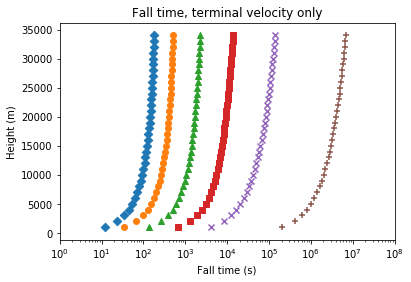

In [39]:
#Plot Bonadonna 2A
#Find cumulative time
cumtime = np.cumsum(1000.0 / htPhiVel, 0)

fig, ax = plt.subplots()
for ix, mark in enumerate(["D","o","^","s","x","+"]):
    ax.scatter(cumtime[:,ix], heights, marker = mark)
    
ax.set_xlim(1,10**8)
ax.set_xscale('log')
ax.set_title('Fall time, terminal velocity only')
ax.set_xlabel('Fall time (s)')
ax.set_ylabel('Height (m)')

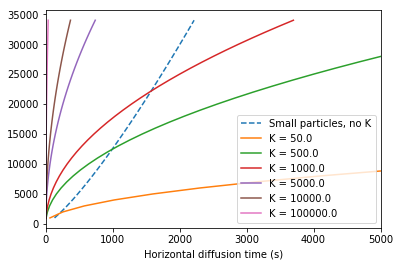

In [40]:
#Plot Bonadonna 2B
K = [50.0, 500.0, 1000.0, 5000.0, 10000.0, 100000.0]
fig, ax = plt.subplots()

ax.plot(diffusionTimePower(heights), heights, '--', label = 'Small particles, no K')

for ix, k in enumerate(K):
    ax.plot(diffusionTimeLinear(heights, k), heights, label = f'K = {k}')

ax.set_xlim(0.0, 5000.0)
ax.set_xlabel('Horizontal diffusion time (s)')
ax.legend()


Text(0,0.5,'Height (m)')

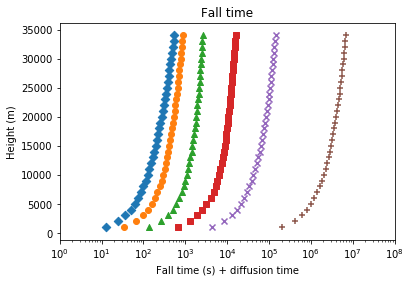

In [41]:
#Plot Bonadonna 2C
#Calculate falltime + horizontal

fig, ax = plt.subplots()
for ix, mark in enumerate(["D","o","^","s","x","+"]):
    totalFall = np.where(cumtime[:,ix] > ftt, 
                         cumtime[:,ix] + diffusionTimePower(heights), 
                         cumtime[:,ix] + diffusionTimeLinear(heights, 10000))
    ax.scatter(totalFall, heights, marker = mark)

ax.set_xlim(1,10**8)
ax.set_xscale('log')
ax.set_title('Fall time')
ax.set_xlabel('Fall time (s) + diffusion time')
ax.set_ylabel('Height (m)')


Text(0,0.5,'Height (m)')

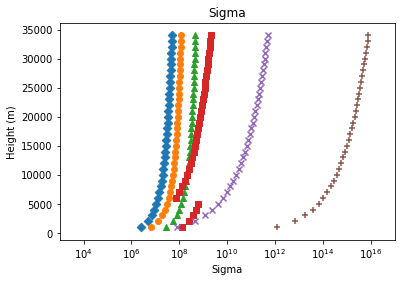

In [42]:
#Plot Bonadonna 2D
# K = 50000
ftt = 3600
K = 50000
fig, ax = plt.subplots()

for ix, mark in enumerate(["D","o","^","s","x","+"]):
    sigma2 = np.where(cumtime[:,ix] > ftt,
                      sigmaPower(EDDY_CONST, cumtime[:,ix] + diffusionTimePower(heights)), 
                      sigmaLinear(K, cumtime[:,ix] + diffusionTimeLinear(heights, K)))
    ax.scatter(sigma2, heights, marker = mark)
#for ix, mark in enumerate(["D","o","^","s","x","+"]):
#    sigma2 = np.where(cumtime[:,ix] > 3600,
#                      sigmaPower(EDDY_CONST, cumtime[:,ix] + diffusionTimePower(heights)), 
#                      sigmaLinear(1000.0, cumtime[:,ix] + diffusionTimeLinear(heights, 1000.0)))
#    ax.scatter(sigma2, heights, marker = mark)
    
ax.set_xlim(10**3,10**17)
ax.set_xscale('log')
ax.set_title('Sigma')
ax.set_xlabel('Sigma')
ax.set_ylabel('Height (m)')

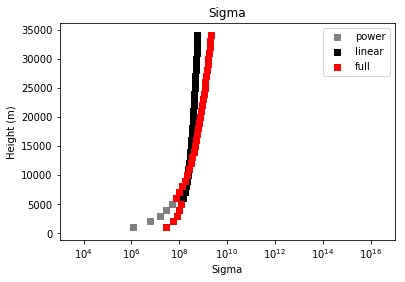

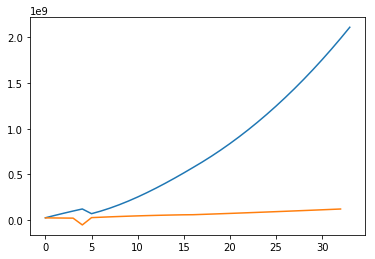

In [43]:
K = 10000
ftt = 3600
fig, ax = plt.subplots()
marks = ["D","o","^","s","x","+"]
ix = 3
mark = marks[ix]
sigma_pow = sigmaPower(EDDY_CONST, cumtime[:,ix] + diffusionTimePower(heights))
sigma_lin = sigmaLinear(K, cumtime[:,ix] + diffusionTimeLinear(heights, K))

sigma_full = np.where(cumtime[:,ix] > ftt,
                      sigma_pow, 
                      sigma_lin)

ax.scatter(sigma_pow, heights, marker = mark, c="gray", label="power")
ax.scatter(sigma_lin, heights, marker = mark, c="k", label="linear")
ax.scatter(sigma_full, heights, marker = mark, c="r", label="full")

#for ix, mark in enumerate(["D","o","^","s","x","+"]):
#    sigma2 = np.where(cumtime[:,ix] > 3600,
#                      sigmaPower(EDDY_CONST, cumtime[:,ix] + diffusionTimePower(heights)), 
#                      sigmaLinear(1000.0, cumtime[:,ix] + diffusionTimeLinear(heights, 1000.0)))
#    ax.scatter(sigma2, heights, marker = mark)
ax.legend()
ax.set_xlim(10**3,10**17)
ax.set_xscale('log')
ax.set_title('Sigma')
ax.set_xlabel('Sigma')
ax.set_ylabel('Height (m)')

plt.show()
plt.plot(sigma_full)
plt.plot(np.diff(sigma_full))






In [44]:
diffCo = np.linspace(1, 50000, 100)

Text(0,0.5,'Heigts (m)')

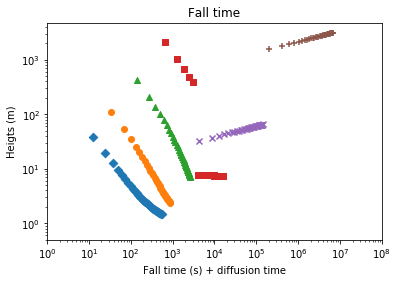

In [45]:
#Diffusion time as proportion of fall time
fig, ax = plt.subplots()
for ix, mark in enumerate(["D","o","^","s","x","+"]):
    totalFall = np.where(cumtime[:,ix] > ftt, 
                         cumtime[:,ix] + diffusionTimePower(heights), 
                         cumtime[:,ix] + diffusionTimeLinear(heights, 10000))
    fallProp = np.where(cumtime[:,ix] > ftt,
                        totalFall/diffusionTimePower(heights),
                       totalFall/diffusionTimeLinear(heights, 10000))
    ax.scatter(totalFall, fallProp, marker = mark)

ax.set_xlim(1,10**8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Fall time')
ax.set_xlabel('Fall time (s) + diffusion time')
ax.set_ylabel('Heigts (m)') #Should this be proportions?

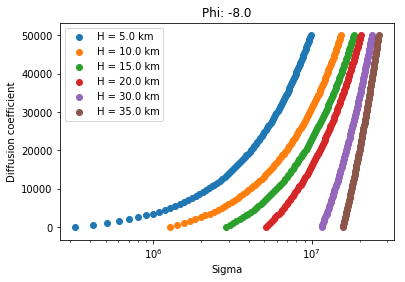

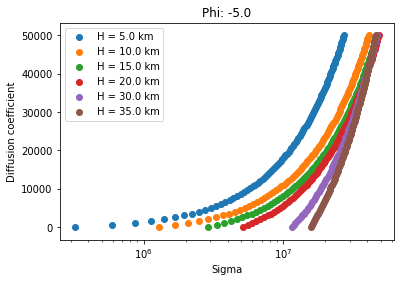

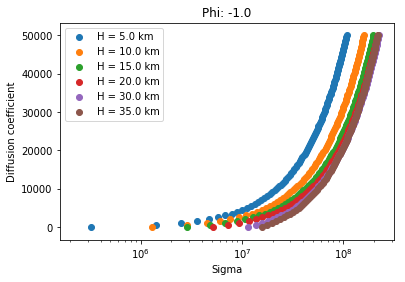

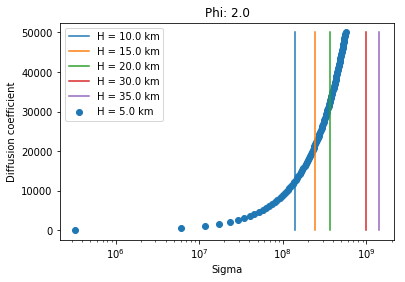

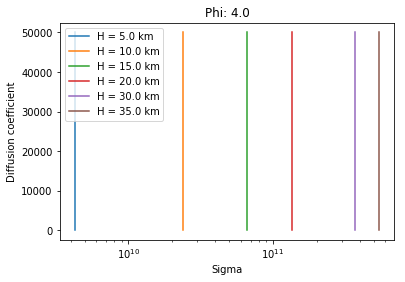

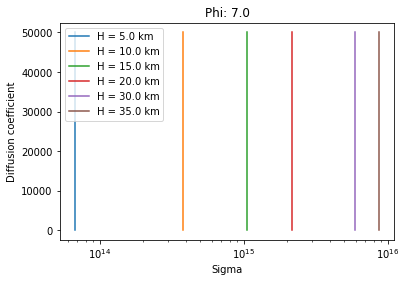

In [56]:
#Fall time + h vs K
h = [5000.0, 10000.0, 15000.0, 20000.0, 30000.0, 35000.0]
diffCo = np.linspace(0.5, 50000, 100)

for ix, mark in enumerate(["D","o","^","s","x","+"]):
    fig, ax = plt.subplots()
    for idx, ht in enumerate(h):
        ft = ht/termVelHt(np.array([ht]), phis)[:,ix]
        #need cumulative
        if (ft < ftt):
            ax.scatter(sigmaLinear(diffCo, ft + diffusionTimeLinear(ht, diffCo)), diffCo, label = f'H = {ht/1000} km')
        else:
            ax.plot(np.repeat(sigmaPower(EDDY_CONST, ft+diffusionTimePower(ht)), 100.0), diffCo, label = f'H = {ht/1000} km')
        
    ax.set_xscale('log')
    ax.set_title(f'Phi: {phis[ix]}')
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Diffusion coefficient')
    ax.legend()
    

In [57]:
#np.cumsum(1000.0 / termVelHt(heights, phis[0]), 0)
#Return a matrix (height * K of diffusionTime)
def diffusionTimeLinearMat(heights, diffCo):
    return(np.reshape(0.0032*heights*heights,(-1,1))/np.reshape(diffCo, (1,-1)))

Text(0,0.5,'Heights')

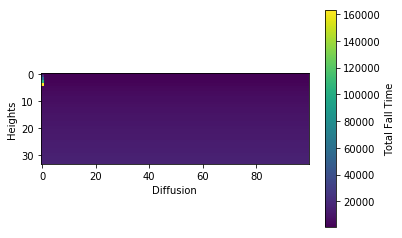

In [90]:
linearTime = diffusionTimeLinearMat(heights, diffCo)
#Constant across K
fTime = np.tile(np.cumsum(1000.0 / termVelHt(heights, phis[3]), 0), (1,100))
#Constant across K (columns)
powerTime = np.tile(np.reshape(diffusionTimePower(heights), (-1,1)), (1,100))

actTimes = np.where(fTime > 3600, 
                    fTime + powerTime,
                    fTime + linearTime)

cb = plt.imshow(actTimes)
plt.colorbar(cb, label="Total Fall Time")
plt.xlabel("Diffusion")
plt.ylabel("Heights")


#+ linearMat

(0.5, 40000)

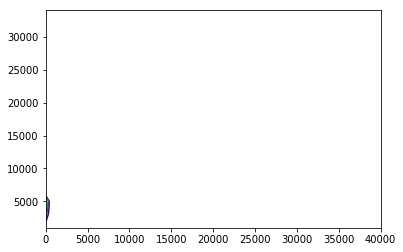

In [91]:
fig, ax = plt.subplots()
CS = ax.contour(diffCo,heights, actTimes)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(0.5, 40000)

(0.5, 40000)

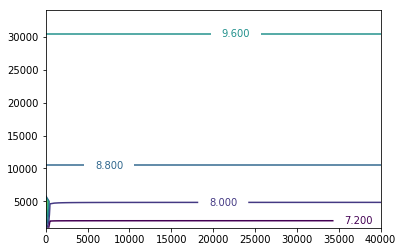

In [92]:
fig, ax = plt.subplots()
CS = ax.contour(diffCo,heights, np.log(actTimes))
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(0.5, 40000)

(34, 100)
(33, 100)
(34, 100)


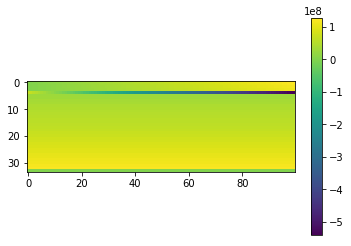

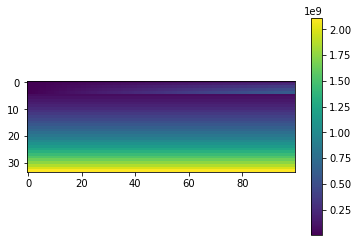

In [138]:
sigma = np.where(fTime > ftt, 
                 8.0*EDDY_CONST/5.0 * (actTimes**2.5),
                 4*diffCo*(fTime + linearTime))
sig_diff = np.diff(sigma, axis=0)
print(sigma.shape)
print(sig_diff.shape)
sig_diff = np.vstack((sig_diff, np.zeros(len(sig_diff[0]))))
print(sig_diff.shape)

cb = plt.imshow(sig_diff)
plt.colorbar(cb)
plt.show()
cb = plt.imshow(sigma)
plt.colorbar(cb)

(0.5, 50000)

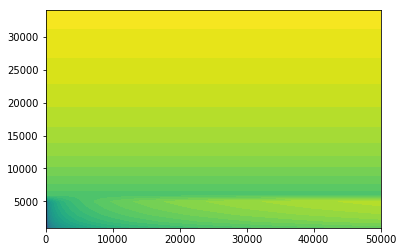

In [139]:
fig, ax = plt.subplots()
CS = ax.contourf(diffCo,heights, np.log(sigma), 40)
# ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(0.5, 50000)

c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


(0.5, 50000)

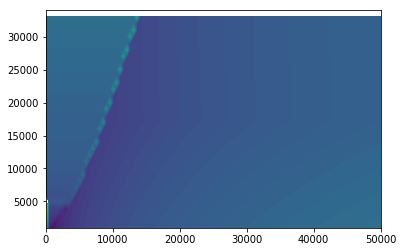

In [136]:
fig, ax = plt.subplots()
CS = ax.contourf(diffCo,heights, np.log(sig_diff), 100)
# ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(0.5, 50000)

In [91]:
np.shape(4*diffCo*(actTimes))

(34, 100)

In [92]:
np.shape(np.cumsum(1000.0 / termVelHt(heights, phis[1]), 0))

(34, 1)

In [93]:
4*diffCo*(np.cumsum(1000.0 / termVelHt(heights, phis[1]), 0) + diffusionTimeLinearMat(heights, K))

array([[6.87174859e+01, 6.94796253e+04, 1.38890533e+05, ...,
        6.73292677e+06, 6.80233768e+06, 6.87174859e+06],
       [1.33633642e+02, 1.35115761e+05, 2.70097888e+05, ...,
        1.30934000e+07, 1.32283821e+07, 1.33633642e+07],
       [1.94988475e+02, 1.97151075e+05, 3.94107161e+05, ...,
        1.91049354e+07, 1.93018914e+07, 1.94988475e+07],
       ...,
       [1.12581555e+03, 1.13830187e+06, 2.27547791e+06, ...,
        1.10307203e+08, 1.11444379e+08, 1.12581555e+08],
       [1.14388216e+03, 1.15656885e+06, 2.31199382e+06, ...,
        1.12077366e+08, 1.13232791e+08, 1.14388216e+08],
       [1.16162822e+03, 1.17451174e+06, 2.34786184e+06, ...,
        1.13816122e+08, 1.14989472e+08, 1.16162822e+08]])

In [94]:
fig, ax = plt.subplots()

4*diffCo*(np.cumsum(1000.0 / termVelHt(heights, phis[6]), 0) + diffusionTimeLinearMat(heights, K)

ax.contour(heights, heights, np.log(8*EDDY_CONST/5.0*(np.cumsum(1000.0 / termVelHt(heights, phis[0]), 0) + diffusionTimePower(heights))**2.5))

SyntaxError: invalid syntax (<ipython-input-94-75dc78278f7f>, line 4)

In [95]:
np.cumsum(1000.0 / termVelHt(heights, phis[0]), 0) + np.reshape(diffusionTimePower(heights)**2.5, (-1,1))

array([[2.00012125e+05],
       [8.00023533e+05],
       [1.80003427e+06],
       [3.20004436e+06],
       [5.00005386e+06],
       [7.20006280e+06],
       [9.80007121e+06],
       [1.28000791e+07],
       [1.62000866e+07],
       [2.00000936e+07],
       [2.42001002e+07],
       [2.88001064e+07],
       [3.38001122e+07],
       [3.92001177e+07],
       [4.50001228e+07],
       [5.12001277e+07],
       [5.78001323e+07],
       [6.48001366e+07],
       [7.22001406e+07],
       [8.00001444e+07],
       [8.82001480e+07],
       [9.68001514e+07],
       [1.05800155e+08],
       [1.15200158e+08],
       [1.25000160e+08],
       [1.35200163e+08],
       [1.45800165e+08],
       [1.56800168e+08],
       [1.68200170e+08],
       [1.80000172e+08],
       [1.92200174e+08],
       [2.04800176e+08],
       [2.17800178e+08],
       [2.31200179e+08]])

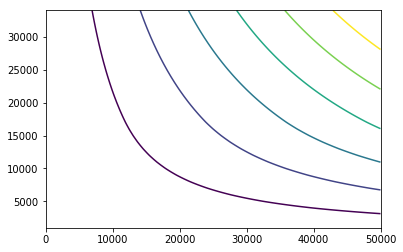

In [96]:
fig, ax = plt.subplots()
ax.contour(diffCo, heights, 4*diffCo*(np.cumsum(1000.0 / termVelHt(heights, phis[3]), 0) + diffusionTimeLinearMat(heights, diffCo)))

In [61]:
cumtime = ht/termVelHt(np.array([5000.0]), phis)
for idx, mark in enumerate(["D","o","^","s","x","+"]):
    if cumtime[:,idx] > ftt:
        fallTime = cumtime[:,idx] + diffusionTimePower(ht)
    else:
        fallTime = cumtime[:,idx] + diffusionTimeLinear(ht, diffCo)

totalFall = np.where(cumtime[:,ix] > ftt, 
                     cumtime[:,ix] + diffusionTimePower(heights), 
                     cumtime[:,ix] + diffusionTimeLinear(heights, 1000.0))

5000.0/termVelHt(np.array([5000.0]), phis)

array([[4.75036608e+01, 1.34360643e+02, 5.37442571e+02, 2.82128457e+03,
        2.08671671e+04, 1.02017261e+06, 4.08069045e+06]])

In [62]:
5000.0/termVelHt(np.array([5000.0]), phis)[:,1]
#diffusionTimeLinear(5000.0, diffCo)

array([134.36064276])

In [63]:
ax.plot(diffusionTimeLinear(5000.0, diffCo), diffCo)

In [64]:
cumtime[:,0]

array([332.52562567])

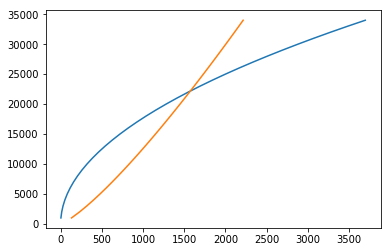

15.608413392986904

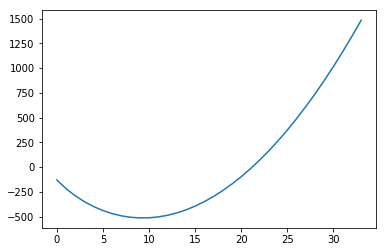

In [129]:
t_lin = diffusionTimeLinear(heights, 1000)
t_pow = diffusionTimePower(heights)
plt.plot(t_lin, heights)
plt.plot(t_pow, heights)
plt.show()
plt.plot(t_lin - t_pow)
min(np.abs(t_lin-t_pow))